# 5_Compare_Performances

In [81]:
from pathlib import Path
import sys
import os.path
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *

import json

from pymodulon.util import explained_variance
from pymodulon.imodulondb import imdb_gene_presence

%matplotlib inline
%config  InlineBackend.figure_format = 'png'

sns.set_style('whitegrid')

In [83]:
performance_metrics = {
    "Method": [
        "GENIE3", "WGCNA", "FLAME", "QUBIC",'ISA',
        "PCA", "Incremental_PCA", "Independent_PCA", "Sparse_Independent_PCA",
        "FastICA", "InfoMax_ICA", 'Picard_ICA', "Sparse_ICA", "NMF", 
        "Factor_Analysis", "Dictionary_Learning", "SparseCoder"
    ],
    "Precision": [
        0.286627, 0.325072, 0.341923, 0.442685, 0.357083,
        0.379601, 0.372706, 0.413706, 0.409233,
        0.361414, 0.415817, 0.436077, 0.387388, 0.366246,
        0.420871, 0.354822, 0.350675
    ],
    "Recall": [
        0.356897, 0.574660, 0.572953, 0.278067, 0.211258,
        0.208374, 0.210040, 0.226852, 0.233011,
        0.583749, 0.282822, 0.286379, 0.529376, 0.294593,
        0.196125, 0.545860, 0.554905
    ],
    "F1 Score": [
        0.188818, 0.307630, 0.309819, 0.256767, 0.185101,
        0.205481, 0.202747, 0.218466, 0.228697,
        0.364539, 0.242075, 0.244736, 0.345653, 0.218582,
        0.204066, 0.331351, 0.331332
    ],
    "MCC": [
        0.217535, 0.351123, 0.354062, 0.286868, 0.214853,
        0.235885, 0.232855, 0.253521, 0.261899,
        0.399736, 0.276325, 0.280999, 0.381831, 0.254393,
        0.240690, 0.363040, 0.365250
    ]
}

# Create the DataFrame
performance_metrics = pd.DataFrame(performance_metrics)
performance_metrics.set_index("Method", inplace=True)

In [84]:
performance_metrics

,Precision,Recall,F1 Score,MCC
Method,,,,
GENIE3,0.286627,0.356897,0.188818,0.217535
WGCNA,0.325072,0.574660,0.307630,0.351123
FLAME,0.341923,0.572953,0.309819,0.354062
QUBIC,0.442685,0.278067,0.256767,0.286868
ISA,0.357083,0.211258,0.185101,0.214853
PCA,0.379601,0.208374,0.205481,0.235885
Incremental_PCA,0.372706,0.210040,0.202747,0.232855
Independent_PCA,0.413706,0.226852,0.218466,0.253521
Sparse_Independent_PCA,0.409233,0.233011,0.228697,0.261899


In [85]:
performance_metrics.index = performance_metrics.index.str.replace('_', ' ')

In [86]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

def plot_performance_metrics(df, save_path='performance_metrics_plot.svg'):
    # Define the colors for each metric
    colors = ['#B999C8', '#F6CD82', '#B8D8A9', '#82A6F6']  # Added a compatible fourth color
    
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Number of methods and metrics
    methods = df.index
    metrics = df.columns
    n_methods = len(methods)
    n_metrics = len(metrics)
    
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(9, 4.7))

    # Bar width and spacing
    bar_width = 0.2  # Width of each bar
    method_spacing = bar_width * n_metrics + 0.2  # Spacing between groups of bars (methods)

    # Positions of the groups on the x-axis
    indices = np.arange(n_methods) * method_spacing

    # Plot each metric
    for i, metric in enumerate(metrics):
        ax.bar(indices + i * bar_width, df[metric], width=bar_width, color=colors[i], label=metric)
    
    # Set the x-axis labels to the method names
    ax.set_xticks(indices + bar_width * (n_metrics / 2 - 0.5))
    ax.set_xticklabels(methods, fontproperties=font_prop, rotation=45, ha="right")
    
    # Add the legend
    ax.legend(prop=font_prop)

    # Apply the custom font to y-axis tick labels individually
    for label in ax.get_yticklabels():
        label.set_fontproperties(font_prop)

    # Remove grid lines
    ax.grid(False)

    # Add a border around the plot area
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    for spine in ax.spines.values():
        spine.set_linewidth(1)

    # Set font for the axis labels and title
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Adjust layout and save the plot as an SVG file with proper bounding box
    plt.tight_layout()
    plt.savefig(save_path, format='svg', bbox_inches='tight')

    # Display the plot
    plt.show()

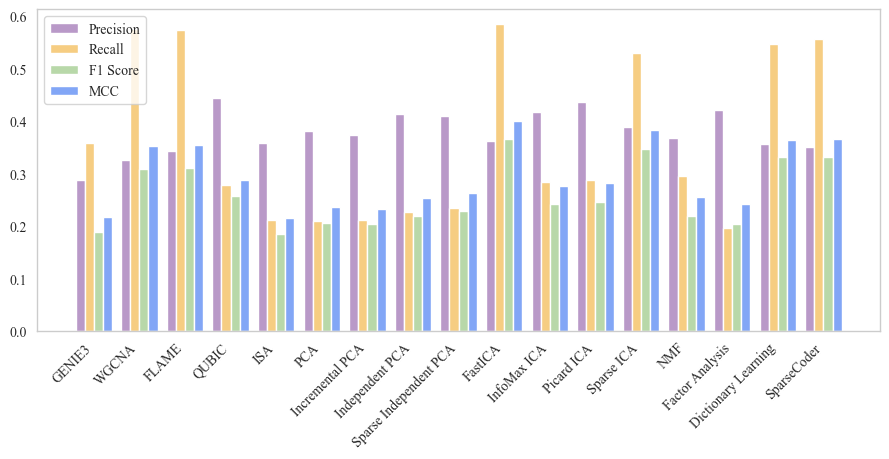

In [87]:
plot_performance_metrics(performance_metrics)

In [88]:
plt.style.use('default')

In [89]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def plot_performance_metrics_line(df, save_path='performance_metrics_plot.svg'):
    # Define the colors for each metric
    colors = ['#B999C8', '#F6CD82', '#B8D8A9', '#82A6F6']  # Four colors for the metrics
    
    # Define different markers for each metric
    markers = ['o', 's', 'D', '^']  # Circle, square, diamond, triangle
    
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Number of methods and metrics
    methods = df.index
    metrics = df.columns
    
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(6, 4))

    # Plot each metric as a line with different markers
    for i, metric in enumerate(metrics):
        ax.plot(methods, df[metric], marker=markers[i], color=colors[i], label=metric, linewidth=2)

    # Set the x-axis labels to the method names
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels(methods, fontproperties=font_prop, rotation=60, ha="right")
    
    # Add the legend
    ax.legend(prop=font_prop)

    # Apply the custom font to y-axis tick labels individually
    for label in ax.get_yticklabels():
        label.set_fontproperties(font_prop)

    # Remove grid lines
    ax.grid(False)
    ax.set_ylim(0.15, 0.62)  # Ensure 0.6 fits within the black-bordered box

    # Add a border around the plot area
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    for spine in ax.spines.values():
        spine.set_linewidth(1)

    # Set font for the axis labels and title
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Adjust layout and save the plot as an SVG file with proper bounding box
    plt.tight_layout()
    plt.savefig(save_path, format='svg', bbox_inches='tight')

    # Display the plot
    plt.show()


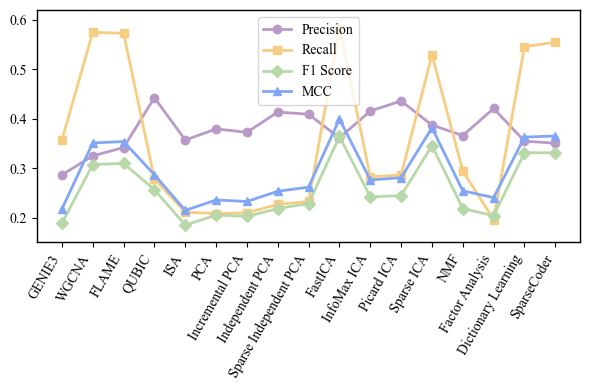

In [90]:
plot_performance_metrics_line(performance_metrics)

In [91]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def plot_performance_metrics_line(df, save_path='performance_metrics_plot.svg'):
    # Define the colors for each metric
    colors = ['#B999C8', '#F6CD82', '#B8D8A9', '#82A6F6']  # Four colors for the metrics
    
    # Load the custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    # Number of methods and metrics
    methods = df.index
    metrics = df.columns
    
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 3))

    # Plot each metric as a line
    for i, metric in enumerate(metrics):
        ax.plot(methods, df[metric], marker='o', color=colors[i], label=metric, linewidth=2)

    # Set the x-axis labels to the method names
    ax.set_xticks(range(len(methods)))
    ax.set_xticklabels(methods, fontproperties=font_prop, rotation=25, ha="right")
    
    # Add the legend outside the plot, to the right, centered vertically
    ax.legend(prop=font_prop, bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.)

    # Apply the custom font to y-axis tick labels individually
    for label in ax.get_yticklabels():
        label.set_fontproperties(font_prop)

    # Remove grid lines
    ax.grid(False)

    # Add a border around the plot area
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    for spine in ax.spines.values():
        spine.set_linewidth(1)

    # Set font for the axis labels and title
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Adjust layout and save the plot as an SVG file with proper bounding box
    plt.tight_layout()
    # plt.savefig(save_path, format='svg', bbox_inches='tight')

    # Display the plot
    plt.show()


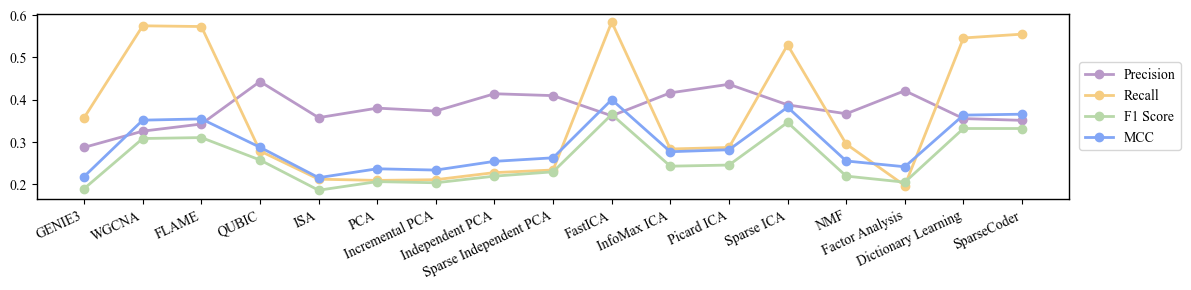

In [92]:
plot_performance_metrics_line(performance_metrics)